In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import os
import skimage.draw
import numpy as np
from tqdm import tqdm
import cv2
import random
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


'''Structure dataset in two folders'''

def create_directory(directory):
    '''
    Creates a new folder in the specified directory if the folder doesn't exist.
    INPUT
        directory: Folder to be created, called as "folder/".
    OUTPUT
        New folder in the current directory.
    '''
    if not os.path.exists(directory):
        os.makedirs(directory)
        
        
label_map = {'Epithelial':1,
             'Lymphocyte':2,
             'Macrophage':4,
             'Neutrophil':3,
            }


# Root directory of the project
ROOT_DIR = os.path.abspath(".")

# Directory of images to run detection on
IMAGES_DEST =  os.path.join(ROOT_DIR, "dataset", "data_processedv0", "images/")
MASKS_DEST = os.path.join(ROOT_DIR, "dataset", "data_processedv0", "masks/")

In [2]:
IMAGES_DEST, MASKS_DEST

('/home/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv0/images/',
 '/home/hasib/MoNuSAC-ISBI-2020/dataset/data_processedv0/masks/')

In [14]:
def pad(im, desired_size = 900):
    "pad image"
    old_size = im.shape[:2] # old_size is in (height, width) format
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format
    im = cv2.resize(im, (new_size[1], new_size[0]))
    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT,
        value=color)
    
    return new_im


def read_nuclei(path):
    "read raw data"

    # Load 4-channel image
    img = skimage.io.imread(path)
    
    # input image
    if len(img.shape) > 2:
        img = img[:,:,:3]
    # mask
    else:
        # do nothing
        pass
        
    return img



def save_nuclei(path, img):
    "save image"
    skimage.io.imsave(path, img)
    

def extract_patches_2d(image, patch_size, max_patches=None, random_state=None):
    """Reshape a 2D image into a collection of patches
    The resulting patches are allocated in a dedicated array.
    Read more in the :ref:`User Guide <image_feature_extraction>`.
    Parameters
    ----------
    image : array, shape = (image_height, image_width) or
        (image_height, image_width, n_channels)
        The original image data. For color images, the last dimension specifies
        the channel: a RGB image would have `n_channels=3`.
    patch_size : tuple of ints (patch_height, patch_width)
        the dimensions of one patch
    max_patches : integer or float, optional default is None
        The maximum number of patches to extract. If max_patches is a float
        between 0 and 1, it is taken to be a proportion of the total number
        of patches.
    random_state : int, RandomState instance or None, optional (default=None)
        Pseudo number generator state used for random sampling to use if
        `max_patches` is not None.  If int, random_state is the seed used by
        the random number generator; If RandomState instance, random_state is
        the random number generator; If None, the random number generator is
        the RandomState instance used by `np.random`.
    Returns
    -------
    patches : array, shape = (n_patches, patch_height, patch_width) or
         (n_patches, patch_height, patch_width, n_channels)
         The collection of patches extracted from the image, where `n_patches`
         is either `max_patches` or the total number of patches that can be
         extracted.
    Examples
    --------
    >>> from sklearn.feature_extraction import image
    >>> one_image = np.arange(16).reshape((4, 4))
    >>> one_image
    array([[ 0,  1,  2,  3],
           [ 4,  5,  6,  7],
           [ 8,  9, 10, 11],
           [12, 13, 14, 15]])
    >>> patches = image.extract_patches_2d(one_image, (2, 2))
    >>> print(patches.shape)
    (9, 2, 2)
    >>> patches[0]
    array([[0, 1],
           [4, 5]])
    >>> patches[1]
    array([[1, 2],
           [5, 6]])
    >>> patches[8]
    array([[10, 11],
           [14, 15]])
    """
    i_h, i_w = image.shape[:2]
    p_h, p_w = patch_size

    if p_h > i_h:
        raise ValueError("Height of the patch should be less than the height"
                         " of the image.")

    if p_w > i_w:
        raise ValueError("Width of the patch should be less than the width"
                         " of the image.")

    image = check_array(image, allow_nd=True)
    image = image.reshape((i_h, i_w, -1))
    n_colors = image.shape[-1]

    extracted_patches = extract_patches(image,
                                        patch_shape=(p_h, p_w, n_colors),
                                        extraction_step=1)

    n_patches = _compute_n_patches(i_h, i_w, p_h, p_w, max_patches)
    if max_patches:
        rng = check_random_state(random_state)
        i_s = rng.randint(i_h - p_h + 1, size=n_patches)
        j_s = rng.randint(i_w - p_w + 1, size=n_patches)
        patches = extracted_patches[i_s, j_s, 0]
    else:
        patches = extracted_patches

    patches = patches.reshape(-1, p_h, p_w, n_colors)
    # remove the color dimension if useless
    if patches.shape[-1] == 1:
        return patches.reshape((n_patches, p_h, p_w))
    else:
        return patches


def reconstruct_from_patches_2d(patches, image_size):
    """Reconstruct the image from all of its patches.
    Patches are assumed to overlap and the image is constructed by filling in
    the patches from left to right, top to bottom, averaging the overlapping
    regions.
    Read more in the :ref:`User Guide <image_feature_extraction>`.
    Parameters
    ----------
    patches : array, shape = (n_patches, patch_height, patch_width) or
        (n_patches, patch_height, patch_width, n_channels)
        The complete set of patches. If the patches contain colour information,
        channels are indexed along the last dimension: RGB patches would
        have `n_channels=3`.
    image_size : tuple of ints (image_height, image_width) or
        (image_height, image_width, n_channels)
        the size of the image that will be reconstructed
    Returns
    -------
    image : array, shape = image_size
        the reconstructed image
    """
    i_h, i_w = image_size[:2]
    p_h, p_w = patches.shape[1:3]
    img = np.zeros(image_size)
    # compute the dimensions of the patches array
    n_h = i_h - p_h + 1
    n_w = i_w - p_w + 1
    for p, (i, j) in zip(patches, product(range(n_h), range(n_w))):
        img[i:i + p_h, j:j + p_w] += p

    for i in range(i_h):
        for j in range(i_w):
            # divide by the amount of overlap
            # XXX: is this the most efficient way? memory-wise yes, cpu wise?
            img[i, j] /= float(min(i + 1, p_h, i_h - i) *
                               min(j + 1, p_w, i_w - j))
    return img

Index:  26
(185, 350, 3) (185, 350)
Ground truth classes:  [0 3]


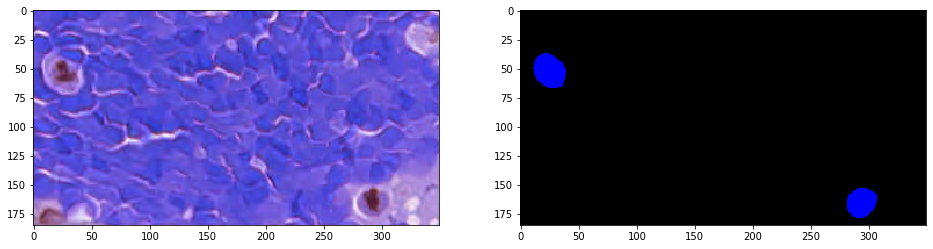

In [6]:
# Load a random image from the images folder
image_fns = sorted(next(os.walk(IMAGES_DEST))[2])
gt_fns = sorted(next(os.walk(MASKS_DEST))[2])


idx = random.randrange(len(image_fns)) # 94 
print("Index: ", idx)


image = skimage.io.imread(os.path.join(IMAGES_DEST, image_fns[idx]))
gt = skimage.io.imread(os.path.join(MASKS_DEST, gt_fns[idx]))

assert image.shape[:2] == gt.shape, "Wrong image or ground truth!"
assert image.dtype == gt.dtype, "Wrong data types!"

print(image.shape, gt.shape)

val1 = gt.flatten()
print("Ground truth classes: ", np.unique(val1))

#label_map = {'Epithelial':1,
#             'Lymphocyte':2,
#             'Macrophage':4,
#             'Neutrophil':3,
#            }

# Stolen from https://stackoverflow.com/questions/16834861/create-own-colormap-using-matplotlib-and-plot-color-scale 
norm=plt.Normalize(0,4) # 5 classes including BG
map_name = matplotlib.colors.LinearSegmentedColormap.from_list("", ["black", "red","yellow","blue", "green"])
#map_name = 'magma'

f, axarr = plt.subplots(1,2, figsize=(16,16))

# idx = 154 all classes
axarr[0].imshow(image, cmap=map_name, norm=norm)
axarr[1].imshow(gt, cmap=map_name, norm=norm)

In [20]:
def extract_patches(whole_slide):
    """
    get patches
    
    https://scikit-learn.org/stable/modules/feature_extraction.html#image-feature-extraction
    https://github.com/scikit-learn/scikit-learn/issues/10910
    """
    
    patches = image.extract_patches_2d(whole_slide, (2, 2), random_state=42)
    return patches

In [21]:
#from sklearn.datasets import load_sample_image
#from sklearn.feature_extraction import image
# Use the array data from the first image in this dataset:

#one_image = load_sample_image("china.jpg")
#print('Image shape: {}'.format(one_image.shape))

#plt.imshow(one_image)

#patches = None
#patches = image.extract_patches_2d(one_image, (2, 2), random_state=42)
#print('Patches shape: {}'.format(patches.shape))
#reconstructed = reconstruct_from_patches_2d(patches, (2, 2, 3))
#print(np.testing.assert_array_equal(one_image, reconstructed))